# test notebook for stella ZAMS calc code

In [1]:
# imports
import numpy as np

import ray
from ray.util.multiprocessing import Pool

import pandas as pd
from scipy import optimize
from scipy.integrate import solve_ivp
from scipy.interpolate import interpn

# from jax import grad, jit
# from jax import jacfwd, jacrev
# from jax.numpy import linalg

# from jax.config import config
# config.update("jax_enable_x64", True)

# constants
import constants as c
from scipy.constants import N_A

# plotting
import matplotlib.pyplot as plt
import seaborn as sb
sb.set_context("talk")
plt.rcParams['font.family'] = 'monospace'   # Fonts
plt.rcParams['font.monospace'] = 'DejaVu Sans Mono'

In [2]:
import interpolate
import energy
import density

Read Sections 18.0, 18.1, and 18.2 of Numerical Recipes, as it will be necessary
to implement the method of shooting to a fitting point (their shootf function) to
solve the boundary-value problem posed by the four coupled ordinary differential
equations of stellar structure and evolution. You will also need a program similar
to the newt function described in Section 9.7 of Numerical Recipes or in the
SciPy documentation to repeatedly call a shootf-like function, calculate updated
boundary values, and ultimately obtain a converged solution. Faster convergence
can usually be obtained by using fractions of the updates suggested by a newt-
like function. Ordinary differential equation (ODE) solvers like those described
in Sections 17.0, 17.1, and 17.2 of Numerical Recipes or the SciPy documentation
are also critical.

In [3]:
def load_inner(Tc, Pc, factor=1e-12):
    """
    Returns reasonable guess for an integration
    starting point exterior to the absolute center
    """
    rho_c = density.density(Pc,Tc, X=0.7)

    m = factor*c.Ms # set start just outside center
    epsilon = energy.energy_gen(rho_c,Tc)
    l = epsilon*m # determine energy generation from pp and CNO
    
    r = (3/(4*np.pi*rho_c))**(1/3) * m**(1/3) # radius start
    
    P = Pc - (3*c.G/(8*np.pi))*((4*np.pi*rho_c/3)**(4/3))*(m**(2/3))
    
    del_rad = energy.del_rad(m, l, P, rho_c, Tc)
    if del_rad > energy.del_ad:
#         print('convective core')
        lnT = np.log(Tc) - (np.pi/6)**(1/3)*c.G*(energy.del_ad*rho_c**(4/3))/Pc*m**(2/3)
        T = np.exp(lnT)
    else:
#         print('radiative core')
        kappa_c = interpolate.interp_k(rho_c,Tc)
        T = (Tc**4 - (1/(2*c.a*c.c)*(3/(4*np.pi))**(2/3)*kappa_c*epsilon*rho_c**(4/3)*m**(2/3)))**(1/4)
    
    return np.array([l, P, r, T])

def load_outer(M_star, L_star, R_star, factor=0.9999):
    """
    Returns reasonable guess for an integration
    starting point interior to the photosphere.
    """
    
    mu = 4/(3+5*0.7)
    surface_g = c.G*M_star/(R_star**2)
    Teff = (L_star/(4*np.pi*c.sb*R_star**2))**(1/4)
    
    def min_rho(rho):
        opacity_pressure = (2/3) * surface_g / interpolate.interp_k(rho,Teff)
        gas_rad_pressure = (1/3)*c.a*Teff**4 + rho * N_A*c.k*Teff/mu
        diff = 1 - opacity_pressure/gas_rad_pressure
        return np.abs(diff**2)
    
    rho_sol = optimize.minimize(min_rho, 1e-8, args=(), method='Nelder-Mead', bounds=[(1e-13,1e-5)])
    if rho_sol.success:
        rho = rho_sol.x[0]
    else:
        print('there\'s no rho for this Teff, log(g)')
        rho = np.nan
    kappa = interpolate.interp_k(rho,Teff)
    P = 2*surface_g/(3*kappa)
    
    return np.array([L_star, P, R_star, Teff])


def odeEZ(m,v):
    l, P, r, T = v
    rho = density.density(P,T, X=0.7) # density
    del_radiative = energy.del_rad(m, l, P, rho, T)
    del_actual = np.minimum(del_radiative, energy.del_ad)
    
    dldm = energy.energy_gen(rho,T, psi=1) #change in Luminosity with enclosed mass
    dPdm = -c.G*m/(4*np.pi*r**4) # change in pressure with enclosed mass
    drdm = 1/(4*np.pi*r**2 * rho) # mass conservation eq.
    dTdm = ((-c.G*m*T)/(4*np.pi*P*r**4))*del_actual # change in temperature with enclosed mass
    
    return np.array([dldm, dPdm, drdm, dTdm])
    

In [4]:
def shooter(vec, M_star=1.0*c.Ms,  n=int(1e5), in_factor=1e-12, out_factor=0.9999, M_fit=0.5):
    
    L_star, Pc, R_star, Tc = vec
    
#     print(vec)
    
    inn = load_inner(Tc, Pc, factor=in_factor)
    outt = load_outer(M_star, L_star, R_star, factor=out_factor)
    
#     print(inn)
#     print(outt)
    
    # protect against low Teff solutions which crash the root finder
    if np.isnan(np.sum(inn)) or np.isnan(np.sum(outt)):
        print('caught a nan in the guess')
        dL = -np.inf
        dP = -np.inf
        dR = -np.inf
        dT = -np.inf
        return np.array([dL, dP, dR, dT])


    exiting = np.logspace(np.log10(in_factor*c.Ms), np.log10(M_fit*M_star), base = 10.0 , num = n)
    entering = np.flipud(np.logspace(np.log10(M_fit*M_star), np.log10(M_star), base = 10.0 , num = n))

    ray.init(num_cpus=4)
    pool = Pool()
    
    sol_i = pool.apply(solve_ivp, [odeEZ, (exiting[0], exiting[-1]), inn, 'RK45', exiting])
#     sol_i = solve_ivp(odeEZ, (exiting[0], exiting[-1]), inn, method='RK45', t_eval=exiting) 
    if sol_i.status == 0:
        print('solved inner')
    else:
        print('failed to solve interior', sol_i.message)
        dL = -np.inf
        dP = -np.inf
        dR = -np.inf
        dT = -np.inf
        ray.shutdown()
        return np.array([dL, dP, dR, dT])
    sol_s = pool.apply(solve_ivp, [odeEZ, (entering[0], entering[-1]), outt, 'RK45', entering])
    if sol_s.status == 0:
        print('solved exterior')
    else:
        print('failed to solve exterior', sol_s.message)
        dL = -np.inf
        dP = -np.inf
        dR = -np.inf
        dT = -np.inf
        ray.shutdown()
        return np.array([dL, dP, dR, dT])
    
    ray.shutdown()
    
    exiting_sol = sol_i.y
    entering_sol = sol_s.y
    
#     print(exiting_sol)
#     print(entering_sol)

    dL = (exiting_sol[0,-1] - entering_sol[0,-1])/L_star
    dP = (exiting_sol[1,-1] - entering_sol[1,-1])/Pc
    dR = (exiting_sol[2,-1] - entering_sol[2,-1])/R_star
    dT = (exiting_sol[3,-1] - entering_sol[3,-1])/Tc
    
    res = np.array([dL, dP, dR, dT])
    
    print(res)
    print(np.sum(res**2))

    return res

In [5]:
def solver(vec_final, M_star=1.0*c.Ms,  n=int(1e5), in_factor=1e-12, out_factor=0.9999, M_fit=0.5):
    
    L_star, Pc, R_star, Tc = vec_final
    
    inn = load_inner(Tc, Pc, factor=in_factor)
    outt = load_outer(M_star, L_star, R_star, factor=out_factor)

    exiting = np.logspace(np.log10(in_factor*c.Ms), np.log10(M_fit*M_star), base = 10.0 , num = n)
    entering = np.flipud(np.logspace(np.log10(M_fit*M_star), np.log10(M_star), base = 10.0 , num = n))

    ray.init(num_cpus=2)
    pool = Pool()
    
    sol_i = pool.apply(solve_ivp, [odeEZ, (exiting[0], exiting[-1]), inn, 'RK45', exiting])
    sol_s = pool.apply(solve_ivp, [odeEZ, (entering[0], entering[-1]), outt, 'RK45', entering])
    
    ray.shutdown()
    
    exiting_sol = sol_i.y
    entering_sol = sol_s.y
    
    # combine mass arrays
    mass = np.concatenate([exiting, np.flipud(entering)], axis=0)
    
    # add mass to final array
    solution = np.zeros((7, mass.shape[0]))
    solution[0] = mass
    
    # combine solution arrays
    sols = np.concatenate([exiting_sol, np.fliplr(entering_sol)], axis=1)
    solution[1:5] = sols
    
    # add density as 6th column
    rho = density.density(solution[2],solution[4], X=0.7)
    solution[5] = rho
    
    # add del_rad as 7th column
#     del_rad = (3/(16*np.pi*c.a*c.c))*(solution[1]*interpolate.interp_k(rho, solution[3])/solution[3]**4)*(solution[0]/(c.G*mass))
    del_rad = energy.del_rad(mass, solution[1], solution[2], rho, solution[4])
    solution[6] = del_rad
    
    return solution

In [30]:
# surface
M_star = 1.3*c.Ms
L_star = (M_star/c.Ms)**(3.5)*c.Ls # eq. 1.88 HKT
R_star = (M_star/c.Ms)**(0.75)*c.Rs # eq. 1.87 HKT
# surface_guess = load_outer(M_star, L_star, R_star, factor=0.9999)
# core
Pc = 2.65e16
# Pc = (3/(8*np.pi))*(c.G*(M_star)**2)/(R_star)**4 # constant density sphere, lower limit!
# Tc = 15e6 
Tc = (1/2)*((4/(3+5*0.7))/(N_A*c.k))*(c.G*M_star)/(R_star) # constant density sphere

vec = np.array([L_star, Pc, R_star, Tc])
args = (M_star, int(1e5), 1e-12, 0.9999, 0.6)

from scipy.optimize import least_squares, root

bounds = ([L_star*1e-1,Pc,R_star*1e-1,Tc], [L_star*1e3, Pc*1e3, R_star*1e1, Tc*1e3])
# bounds = [(L_star*1e-2,L_star*1e2),(Pc,Pc*1e2),(R_star*1e-2,R_star*1e2),(Tc,Tc*1e2)]

# x_scale = np.array([1e31, 1e14, 1e9, 1e6])

# todo, set x_scale for each variable to enable better tolerance estimate
final = least_squares(shooter, vec, args=args, bounds=bounds, 
                      method='dogbox', loss='arctan', 
                      gtol=1e-15, xtol=None, ftol=None, 
                      x_scale='jac', # x_scale
                     )

# final = root(shooter, vec, args=args)


2023-04-13 15:51:14,683	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 15:51:48,726	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 15:52:14,850	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 15:52:46,643	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 15:53:13,786	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior
there's no rho for this Teff, log(g)
caught a nan in the guess


2023-04-13 15:53:57,486	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 15:54:22,949	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 15:54:49,965	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 15:55:18,054	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 15:55:52,259	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 15:56:30,030	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 15:57:02,601	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 15:57:37,362	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 15:58:03,301	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 15:58:27,072	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 15:58:49,541	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 15:59:23,154	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 15:59:52,232	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:00:18,514	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:00:41,590	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:01:05,676	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:01:26,141	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:01:46,158	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:02:08,569	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:02:26,666	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:02:47,804	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:03:07,590	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:03:28,932	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:03:52,803	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:04:16,051	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:04:42,785	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:05:12,826	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:05:34,301	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:06:05,849	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:06:38,384	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:07:15,623	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:07:50,839	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:08:22,137	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:08:52,932	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:09:24,252	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:09:58,432	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:10:29,645	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:10:59,103	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:11:30,562	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:12:10,163	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:12:43,480	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:13:17,405	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:13:57,087	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:14:29,463	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:14:59,654	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:15:23,150	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:15:53,761	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:16:21,753	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:16:47,761	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:17:15,397	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:17:52,729	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:18:20,060	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:18:56,282	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:19:24,904	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:19:58,234	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:20:23,905	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:20:45,062	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:21:05,053	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:21:26,253	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:21:50,719	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:22:14,722	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:22:32,341	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:22:52,486	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:23:10,588	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:23:28,681	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:23:46,883	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:24:05,741	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:24:26,144	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:24:45,536	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:25:10,818	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:25:31,709	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:25:51,697	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:26:10,717	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:26:31,092	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:26:52,121	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:27:12,057	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:27:33,147	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:27:51,739	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:28:10,915	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:28:31,125	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:28:50,995	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:29:10,945	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:29:31,524	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:29:50,705	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:30:12,117	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:30:33,534	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:30:56,596	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


2023-04-13 16:31:18,056	INFO worker.py:1553 -- Started a local Ray instance.


solved inner
solved exterior


In [31]:
final

     message: `gtol` termination condition is satisfied.
     success: True
      status: 1
         fun: [-1.162e-05  4.202e-04  5.844e-04 -4.732e-05]
           x: [ 9.584e+33  1.956e+17  9.865e+10  1.670e+07]
        cost: 2.6019640270012116e-07
         jac: [[-1.032e-34 -1.454e-17 -3.202e-13  4.788e-07]
               [-7.672e-36 -4.218e-18  2.466e-12  6.222e-08]
               [ 6.083e-36 -2.157e-18 -1.625e-12  1.014e-08]
               [-1.607e-35 -6.052e-17  3.192e-12  5.601e-07]]
        grad: [ 2.292e-39  3.958e-28 -6.050e-17 -3.680e-18]
  optimality: 6.049772913116271e-17
 active_mask: [0 0 0 0]
        nfev: 22
        njev: 18

In [32]:
solution = solver(final.x, M_star=args[0],  n=args[1], in_factor=args[2], out_factor=args[3], M_fit=args[4])

2023-04-13 16:31:41,584	INFO worker.py:1553 -- Started a local Ray instance.


(0.0, 1.1)

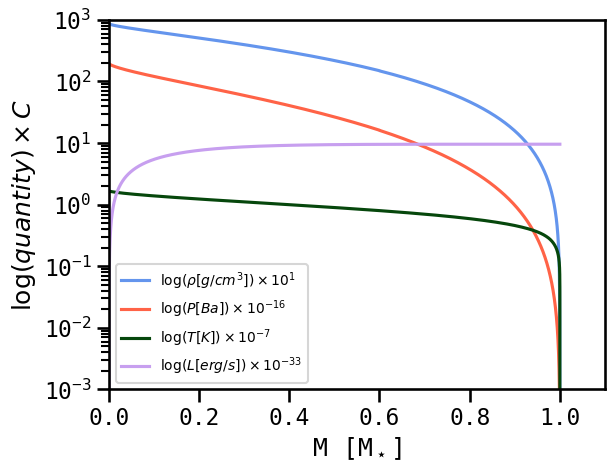

In [33]:
# a figure like 9.1 in HKT but in mass space, y-values near 1

plt.plot(solution[0]/M_star, solution[5]*1e1, color='cornflowerblue', label=r'$\log(\rho [g/cm^3])\times10^1$')
plt.plot(solution[0]/M_star, solution[2]*1e-15, color='tomato', label=r'$\log(P [Ba])\times10^{-16}$')
plt.plot(solution[0]/M_star, solution[4]*1e-7, color='xkcd:forest green', label=r'$\log(T [K])\times10^{-7}$')
plt.plot(solution[0]/M_star, solution[1]*1e-33, color='xkcd:lavender', label=r'$\log(L [erg/s])\times10^{-33}$')

plt.yscale('log')
plt.xlabel(r'M [M$_\star$]')
plt.ylabel(r'$\log(quantity)\times C$')
plt.legend(fontsize=10)
plt.ylim(1e-3,1e3)
plt.xlim(0,1.1)


(0.0, 1.1)

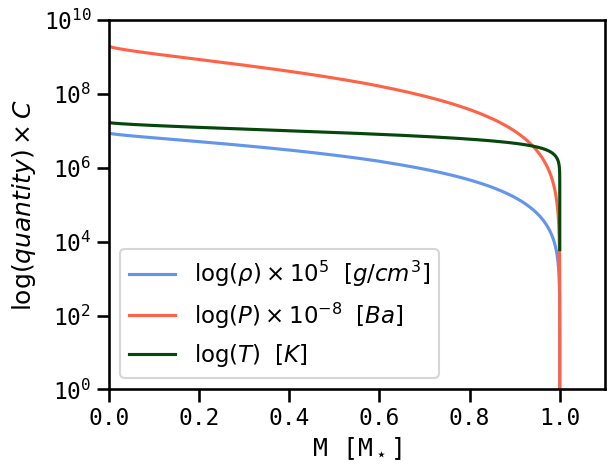

In [34]:
# reproduce figure 9.1 in HKT but in mass space

plt.plot(solution[0]/M_star, solution[5]*1e5, color='cornflowerblue', label=r'$\log(\rho)\times10^5$ $[g/cm^3]$')
plt.plot(solution[0]/M_star, solution[2]*1e-8, color='tomato', label=r'$\log(P)\times10^{-8}$ $[Ba]$')
plt.plot(solution[0]/M_star, solution[4], color='xkcd:forest green', label=r'$\log(T)$ $[K]$')

plt.yscale('log')
plt.xlabel(r'M [M$_\star$]')
plt.ylabel(r'$\log(quantity)\times C$')
plt.legend()
plt.ylim(1,1e10)
plt.xlim(0,1.1)

In [35]:
with open('converged_interior.npy', 'wb') as f:
    np.save(f, solution)